# Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

     |████████████████████████████████| 4.9 MB 28.8 MB/s 
     |████████████████████████████████| 462 kB 19.2 MB/s 


In [ ]:
entities = ["FOOD","DRINKS","SERVICE","AMBIENCE","LOCATION","RESTAURANT"]   #6
attributes = ["GENERAL","PRICES","QUALITY","STYLE_OPTIONS","MISCELLANEOUS"] #5
polarities = ["negative","neutral","positive"]                              #3
vector_size = len(entities) * len(attributes)*len(polarities)

In [ ]:
def labels_encoding(opinions):
  label = list("0" * vector_size)
  for opinion in opinions:
        row_dict = opinion.attrib
        ent = row_dict["category"].split("#")[0]
        att = row_dict["category"].split("#")[1]
        pol = row_dict["polarity"]
        i = entities.index(ent)*len(attributes)*len(polarities) + attributes.index(att)*len(polarities)+polarities.index(pol)
        label[i]="1"
  label = "".join(label)
  # print(label)
  return label

In [ ]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['label'] = labels_encoding(sent[1])
      rows_list.append(row_dict)
    else:
      rows_list.append({'rid':np.nan,'txt':txt,'OOTS':True})
df = pd.DataFrame(rows_list)
#target	category	polarity	from	to	rid	txt	entity	aspect

In [ ]:
df

In [ ]:
import spacy
nlp = spacy.load('en')

df.txt = df.txt.str.lower()

aspect_terms = []
for review in nlp.pipe(df.txt):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
df['aspect_terms'] = aspect_terms
df.head(10)

In [ ]:
df[["txt","aspect_terms"]].values[8]

## Data cleaning

In [ ]:
df['target'].value_counts()

In [ ]:
df[['entity', 'aspect']] = df['category'].str.split('#', 1, expand=True)
df = df.drop(['category'], axis=1)

In [ ]:
df['polarity'] = df['polarity'].map(lambda x: 0 if x == "negative" else 2 if x=="positive" else 1)

In [ ]:
df['to'].value_counts()

In [ ]:
# df['from'] = pd.to_numeric(df['from'])
# df['to'] = pd.to_numeric(df['to'])
df.info()

# Sentiment Analysis with BERT

## DatasetPreparation

In [ ]:
df=df[["txt","polarity"]]

In [ ]:
df.polarity.value_counts()

2    801
0    276
1    238
Name: polarity, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import tensorflow_text as text  # Registers the ops.

x_train, x_test, y_train, y_test = train_test_split(df['txt'],df['polarity'],stratify=df['polarity'])
# hot encoding of the polarity
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)
y_train.shape

(986, 3)

## Model Training

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4") #encoding using bert str -> vector[]

In [ ]:
# Example of usage of the preprocessing+embedding.

def get_sentence_embedding(sentences):
  return bert_encoder(bert_preprocess(sentences))["pooled_output"]  #Pooled output is a vector of 7

get_sentence_embedding(["hello my name is"])

In [ ]:
#Creation of the model
from tensorflow.keras import layers
import tensorflow as tf
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = bert_preprocess(input_txt)
bert_encoder.trainable = False                                    #Freezed the weights of BERT.
encoded_text = bert_encoder(preprocess_text)

#Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(64,activation="relu")(l)
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt],outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
batch_size = 8
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
METRICS = [
           tf.keras.metrics.CategoricalAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=[x_test,y_test], callbacks=[callback])

Epoch 1/10
124/124 [==============================] - 24s 119ms/step - loss: 0.9788 - categorical_accuracy: 0.5994 - precision: 0.6171 - recall: 0.4544 - val_loss: 0.9325 - val_categorical_accuracy: 0.6079 - val_precision: 0.6130 - val_recall: 0.6018
Epoch 2/10
124/124 [==============================] - 14s 110ms/step - loss: 0.9302 - categorical_accuracy: 0.6095 - precision: 0.6376 - recall: 0.5122 - val_loss: 0.9247 - val_categorical_accuracy: 0.6079 - val_precision: 0.6436 - val_recall: 0.5380
Epoch 3/10
124/124 [==============================] - 14s 112ms/step - loss: 0.9171 - categorical_accuracy: 0.5984 - precision: 0.6494 - recall: 0.5091 - val_loss: 0.9154 - val_categorical_accuracy: 0.6109 - val_precision: 0.6705 - val_recall: 0.5258
Epoch 4/10
124/124 [==============================] - 14s 114ms/step - loss: 0.8779 - categorical_accuracy: 0.6166 - precision: 0.6671 - recall: 0.5385 - val_loss: 0.8965 - val_categorical_accuracy: 0.6079 - val_precision: 0.6311 - val_recall: 0.5

## Examples

In [ ]:
#Example
polarities = ["negative","neutral","positive"]
exml_sentence = "The service is not good."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "This food is very good."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "The pastas are incredible, the risottos (particularly the sepia) are fantastic and the braised rabbit is amazing."
out = model.predict([exml_sentence])
polarities[np.argmax(out)]

'positive'

In [ ]:
exml_sentence = "Delivery guy sometimes get upset if you don't tip more than 10%."
out = model.predict([exml_sentence])
polarities[np.argmax(out)] 

'negative'

In [ ]:
exml_sentence = "the pasta was good but the stake was bad."
out = model.predict([exml_sentence])
out 

array([[0.24271291, 0.1443338 , 0.61295325]], dtype=float32)

# Sentiment Analysis with PreTrainedModel

This a bert-base-multilingual-uncased model finetuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

This model is intended for direct use as a sentiment analysis model for product reviews in any of the six languages above, or for further finetuning on related sentiment analysis tasks.
https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
pretrained_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
txt = ["I like you. I love you","i hate you."]

### Primo metodo

In [ ]:
inputs = bert_preprocess(txt)["input_word_ids"].numpy()
inputs = torch.tensor(inputs)
inputs
with torch.no_grad():
    logits = pretrained_model(inputs).logits
    predicted_class_id = logits.argmax().item()

In [ ]:
def get_stars(text):
  single_input = tokenizer(text, return_tensors="pt")
  with torch.no_grad():
      logits = pretrained_model(**single_input).logits
  return logits.numpy()

In [ ]:
print(single_input)

{'input_ids': tensor([[  101,   151, 11531, 10855,   119,   151, 11157, 10855,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [ ]:
inputs

array([[ 101, 1045, 2066, 2017, 1012, 1045, 2293, 2017,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 1045, 5223, 2017, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

In [ ]:
predicted_class_id = np.argmax(logits, axis=1).item()
predicted_class_id

ValueError: ignored

In [ ]:
arr = np.array(inputs['input_ids'])
arr = arr.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
torch.tensor(arr)

TypeError: ignored

### Secondo metodo

In [ ]:
inputs = tokenizer(txt)
inputs = inputs["input_ids"]
inputs

[[101, 151, 11531, 10855, 119, 151, 11157, 10855, 102],
 [101, 151, 39487, 10855, 119, 102]]

In [ ]:
def pad_text(texts, N):
  res = np.eye(len(texts),N)
  for i,t in enumerate(texts):
    t = np.append(t, [0] * (N - len(t)))
    res[i]=t
  return res

inputs = pad_text(inputs,512)
inputs = np.array(inputs)
inputs = inputs.astype(np.int32)

In [ ]:
inputs = inputs.astype(np.int32)

In [ ]:
inputs = torch.tensor(inputs)
token_type = [0]*512
mask = [1]*512

In [ ]:
mask = [mask]
token_type = [token_type]

In [ ]:
{'input_ids': tensor([[  101,   151, 11531, 10855,   119,   151, 11157, 10855,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


NameError: ignored

In [ ]:
dizionario = {'input_ids':inputs[0][None, :]}
dizionario['token_type_ids']=torch.tensor(token_type)
dizionario['attention_mask']=torch.tensor(mask)

In [ ]:
dizionario

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
with torch.no_grad():
    logits = pretrained_model(**dizionario).logits
    predicted_class_id = logits.argmax().item()

In [ ]:
logits

tensor([[ 0.3840,  0.6388,  0.4244, -0.0740, -0.9209]])

In [ ]:
predicted_class_id = logits[0].argmax().item()
predicted_class_id

1

In [ ]:
def adapt_tokenizer(words):
  shape = words.shape
  words = layers.Flatten(words)
  tokens = tokenizer(words)
  return np.array([tokens])

In [ ]:
## Creare un modello e aggiungerci preprocessing + questo modello.
from tensorflow.keras import layers
import tensorflow as tf
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = tokenizer(input_txt)
with torch.no_grad():
    logits = model(**inputs).logits
    #Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt],outputs=[l])
model.summary()

ValueError: ignored

In [ ]:
def method(nomi):
  return nomi

input_txt = layers.Input(shape=(512,), dtype=tf.string, name="text")
tokens = method(input_txt)
l = layers.Dense(3,activation="softmax",name="output")(tokens)

model2 = tf.keras.Model(inputs=[input_txt], outputs=[l])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 512)]             0         
                                                                 
 output (Dense)              (None, 3)                 1539      
                                                                 
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________


## Dataset augmentation

In [ ]:
def ds_augment(df,model):
  stelle = []
  for index, row in df.iterrows():
    single_input = tokenizer(row['txt'], return_tensors="pt")
    with torch.no_grad():
      logits = model(**single_input).logits
    stelle.append(logits)
  return stelle    

In [ ]:
stars = ds_augment(df,pretrained_model)

In [ ]:
stars

In [ ]:
star_new = list(map(lambda x: x[0].numpy(), stars))

In [ ]:
star_df = pd.DataFrame(data=star_new,columns=["1star","2star","3star","4star","5star"])

In [ ]:
df_new = pd.concat([df, star_df], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
x_train, x_test, y_train, y_test = train_test_split(df_new[['txt','1star','2star','3star','4star','5star']],df['polarity'],stratify=df['polarity'])
# hot encoding of the polarity
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)
y_train.shape

(986, 3)

In [ ]:
input_txt = layers.Input(shape=(), dtype=tf.string, name="text")
preprocess_text = bert_preprocess(input_txt)
bert_encoder.trainable=False                                    #Freezed the weights of BERT.
encoded_text = bert_encoder(preprocess_text)

input_stars = layers.Input(shape=(5),name="stars")

#Neural nel layers
l = layers.Dropout(0.1, name="dropout")(encoded_text["pooled_output"])
l = layers.Dense(64,activation="relu")(l)
l = layers.concatenate([input_stars, l])
l = layers.Dense(32, activation="relu")(l)
l = layers.Dense(3,activation='softmax', name="output")(l)

#Generate the model
model = tf.keras.Model(inputs=[input_txt,input_stars],outputs=[l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

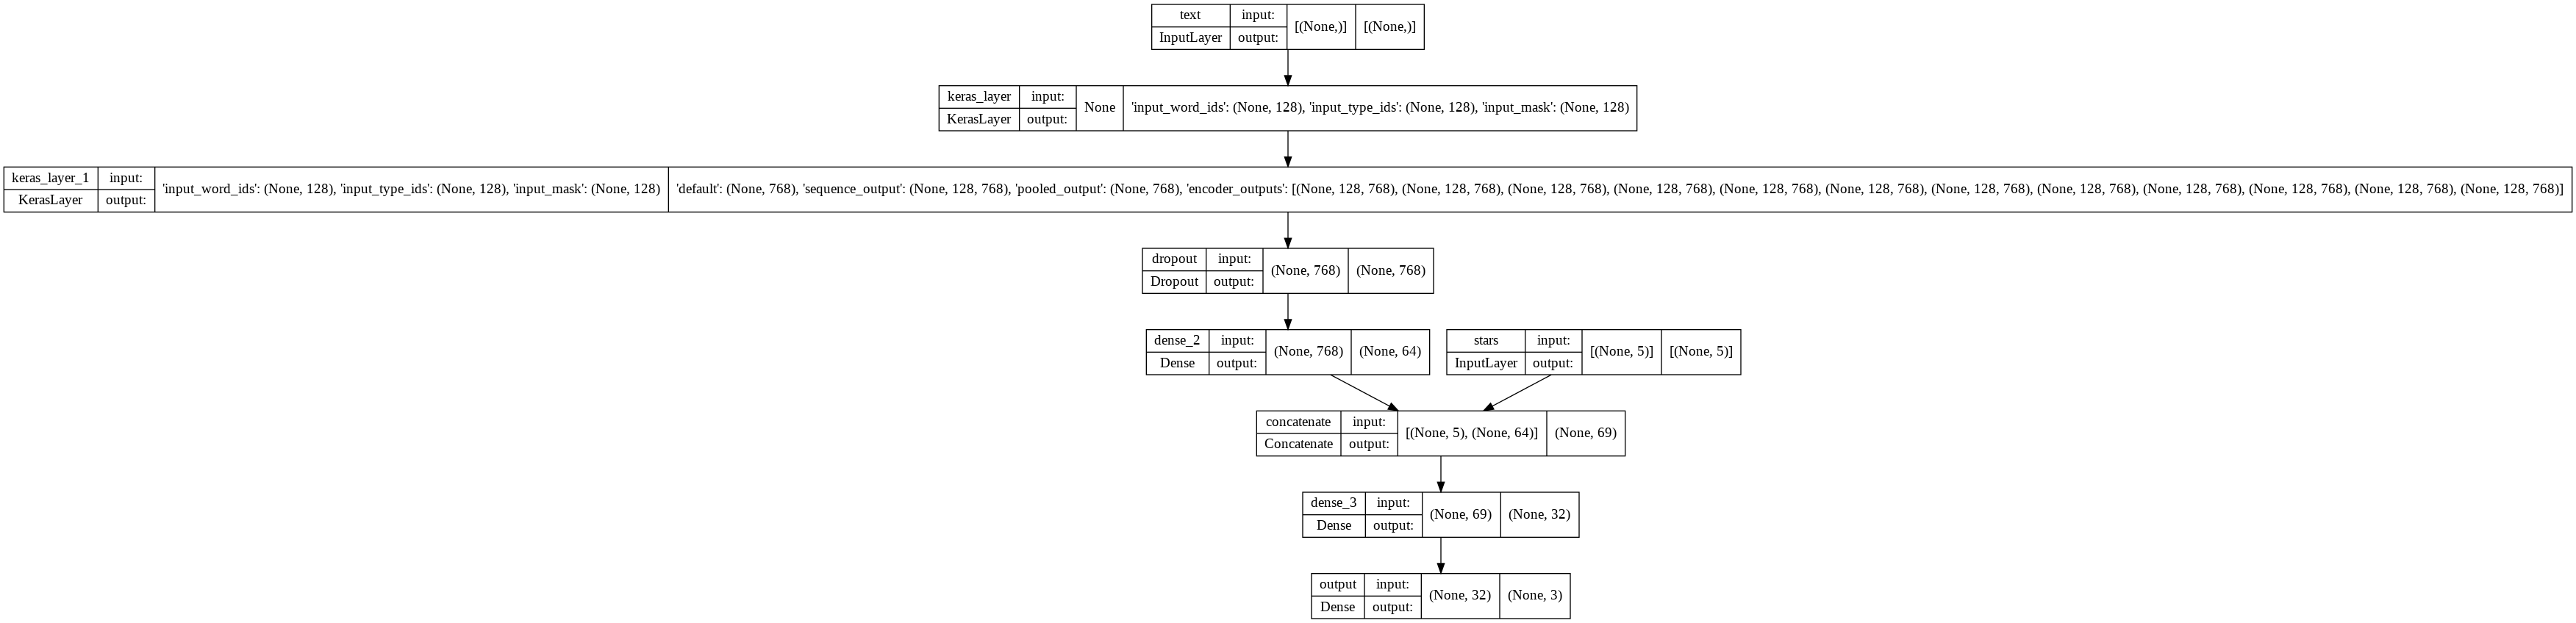

In [ ]:
import tensorflow
tensorflow.keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)

In [ ]:
# Save dataset.
# df_new.to_pickle("/content/drive/MyDrive/HLT/datasetwstars.pkl")  

In [ ]:
batch_size = 8
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
METRICS = [
           tf.keras.metrics.CategoricalAccuracy(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall()
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.fit([x_train['txt'],x_train[['1star','2star','3star','4star','5star']]], y_train, batch_size=batch_size, epochs=epochs, validation_data=[[x_test['txt'],x_test[['1star','2star','3star','4star','5star']]],y_test], callbacks=[callback])

Epoch 1/10
124/124 [==============================] - 47s 257ms/step - loss: 0.7363 - categorical_accuracy: 0.6937 - precision: 0.7506 - recall: 0.6288 - val_loss: 0.6785 - val_categorical_accuracy: 0.7264 - val_precision: 0.7635 - val_recall: 0.6869
Epoch 2/10
124/124 [==============================] - 31s 247ms/step - loss: 0.6782 - categorical_accuracy: 0.7221 - precision: 0.7793 - recall: 0.6481 - val_loss: 0.6849 - val_categorical_accuracy: 0.7204 - val_precision: 0.8000 - val_recall: 0.5957
Epoch 3/10
124/124 [==============================] - 30s 246ms/step - loss: 0.6782 - categorical_accuracy: 0.7181 - precision: 0.7743 - recall: 0.6471 - val_loss: 0.6372 - val_categorical_accuracy: 0.7112 - val_precision: 0.7885 - val_recall: 0.6687
Epoch 4/10
124/124 [==============================] - 33s 269ms/step - loss: 0.6650 - categorical_accuracy: 0.7211 - precision: 0.7778 - recall: 0.6389 - val_loss: 0.6675 - val_categorical_accuracy: 0.7143 - val_precision: 0.7595 - val_recall: 0.6

### Test

In [ ]:
testo = "the spaghetti were really good but the porc was not so good."
stars = get_stars(testo)[0]
stars

array([-1.141321  ,  0.92280924,  1.8750765 ,  0.7300526 , -2.0902185 ],
      dtype=float32)

In [ ]:
riga = pd.DataFrame([[testo]],columns=["text"])
riga = pd.concat([riga, pd.DataFrame([stars],columns=['1star','2star','3star','4star','5star'])], axis = 1)

In [ ]:
riga["1star"] = pd.to_numeric(riga["1star"])
riga["5star"] = pd.to_numeric(riga["5star"])
riga["4star"] = pd.to_numeric(riga["4star"])
riga["3star"] = pd.to_numeric(riga["3star"])
riga["2star"] = pd.to_numeric(riga["2star"])

In [ ]:
model.predict([riga['text'],riga[['1star','2star','3star','4star','5star']]])

array([[0.28716063, 0.27771416, 0.43512523]], dtype=float32)

In [ ]:
def get_stars(txt):
  single_input = tokenizer(txt, return_tensors="pt")
  with torch.no_grad():
    logits = pretrained_model(**single_input).logits
  return logits.numpy()

In [ ]:
def test_function(txt):
  stars = get_stars(txt)[0]
  riga = pd.DataFrame([[txt]],columns=["text"])
  riga = pd.concat([riga, pd.DataFrame([stars],columns=['1star','2star','3star','4star','5star'])], axis = 1)
  riga["1star"] = pd.to_numeric(riga["1star"])
  riga["5star"] = pd.to_numeric(riga["5star"])
  riga["4star"] = pd.to_numeric(riga["4star"])
  riga["3star"] = pd.to_numeric(riga["3star"])
  riga["2star"] = pd.to_numeric(riga["2star"])
  out = model.predict([riga['text'],riga[['1star','2star','3star','4star','5star']]])
  index = np.argmax(out)
  sentiments = ["bad","neutral","positive"]
  return "Sentiment: {} probability {}".format(sentiments[index],out[0][index])

In [ ]:
test_function("the pasta was really bad.")

'Sentiment: bad probability 0.8716690540313721'

In [ ]:
!pip install gradio
import gradio as gr
iface = gr.Interface(fn=test_function, inputs=["text"], outputs=["text"]).launch()

In [ ]:
# model.save("/content/drive/MyDrive/HLT/model.h5")

# Modelling

In [ ]:
!pip install transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")   #preprocessing layer str -> str for bert
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4") #encoding using bert str -> vector[]

In [ ]:
max_len = 384

def create_test_input_from_text(texts):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }
    for sentence in texts:
        input_ids = []
        for idx, word in enumerate(sentence.split()):
            ids = slow_tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids)
            num_tokens = len(ids)
            
        # Pad and create attention masks.
        # Skip if truncation is needed
        input_ids = input_ids[:max_len - 2]

        input_ids = [101] + input_ids + [102] # add starting and end tokens.
        n_tokens = len(input_ids)
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    return x, n_tokens

test_inputs = ["alex lives in london"]
x_test, n_tokens = create_test_input_from_text(test_inputs)
print('input tokens')
print(x_test[0][0][:n_tokens])
pred_test = model.predict(x_test)
pred_tags = np.argmax(pred_test,2)[0][:n_tokens]  # ignore predictions of padding tokens
print(pred_tags)

In [ ]:
txt = "ciao mi chiamo paolo"
f1 = slow_tokenizer.tokenize(txt)
f2 = slow_tokenizer.tokenize(txt)
fulty = f1+f2
indexed_tokens = slow_tokenizer.encode(text = txt, text_pair=txt)
indexed_tokens

In [ ]:
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"

encoded_dict = slow_tokenizer(sequence_a, sequence_b)
encoded_dict

In [ ]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

In [ ]:
res = encoder.predict([encoded_dict['input_ids'],encoded_dict['token_type_ids'],encoded_dict['attention_mask']])
res

In [ ]:
res[:,0,:]

In [ ]:
res[0][0].shape

In [ ]:
#Prova modello
def tf_count(t, val):
    elements_equal_to_value = tf.equal(t, val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints)
    return count
    
def build_model():
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )

    class_input = embedding['pooler_output']
    until_index = tf_count(token_type_ids, 0)-1
    ner_input = embedding[0][:,1:until_index,:]

    net = layers.Dense(64, activation='relu',name='class_layer1')(class_input)
    net = layers.Dropout(0.2)(net)
    net = layers.Dense(32, activation='relu',name='class_layer2')(net)
    net = layers.Dropout(0.2)(net)
    class_out = layers.Dense(2, activation='softmax',name='class_output')(net)

    embedding = layers.Dropout(0.3)(embedding[0])
    ner_out = layers.Dense(3, activation='softmax',name='ner_output')(ner_input)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[class_out,ner_out],
    )
    return model

prova = build_model()

In [ ]:
ner_loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = ner_loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

class_loss = tf.keras.losses.CategoricalCrossentropy()


lossWeights = [1.0, 1.0]
optimizer = keras.optimizers.Adam(learning_rate=3e-5)
model.compile(optimizer=optimizer, loss=[class_loss, masked_ce_loss], metrics=['accuracy'], loss_weights=lossWeights)

In [ ]:
prova.summary()

In [ ]:
res = prova.predict(x_test)

In [ ]:
res[0].shape

In [ ]:
res[1].shape

In [ ]:
tf.keras.utils.plot_model(prova)

# Parte Nuova

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import os
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 30.1 MB/s 
     |████████████████████████████████| 880 kB 50.1 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=be46baec176bafbc1331118da5fca11289edd25bae57fad306c04331d7bb92b6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
import zipfile
import pandas as pd
import xml.etree.ElementTree as ET
!pip install tensorflow_text

dataset_path = "/content/drive/MyDrive/HLT/RestaurantTR.zip"
with zipfile.ZipFile(dataset_path,"r") as zip_ref:
    zip_ref.extractall("./dataset")

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 48.9 MB/s 


In [5]:
import numpy as np
xml_path = "/content/dataset/ABSA15_RestaurantsTrain/ABSA-15_Restaurants_Train_Final.xml"
mytree = ET.parse(xml_path)
reviews = mytree.getroot()
rows_list = []
for rew in reviews:
  rid = rew.attrib['rid']
  for sent in rew[0]: #cicle on single sentence in review.
    sid = sent.attrib['id']
    txt = sent[0].text
    if len(sent)>1:
      row_dict = {}
      row_dict['rid'] = rid # Review id
      row_dict['sid'] = sid # Sentence id
      row_dict['txt'] = txt
      row_dict['OOTS'] = False
      row_dict['f'] = 'yes'
      for opinion in sent[1]:
        op_dict = opinion.attrib
        rows_list.append({**row_dict,**op_dict})
    else:
      rows_list.append({'rid':rid,'sid':sid,'txt':txt,'OOTS':True,'target':np.nan,'category':np.nan,'polarity':np.nan,'from':0,'to':0,'f':'no'})
df = pd.DataFrame(rows_list)

In [33]:
df['sid'].value_counts()

1726427:1    8
744478:1     7
490565:4     6
1126814:0    5
630914:2     5
            ..
1460715:4    1
1460715:5    1
1470286:1    1
1470334:0    1
958809:4     1
Name: sid, Length: 1315, dtype: int64

In [6]:
import itertools
categories = set(df[df['category'].notna()]['category'].values)
polarities = set(df[df['polarity'].notna()]['polarity'].values)
cat_pol_couples = set(list(itertools.product(categories,polarities)))

In [12]:
print(len(cat_pol_couples))

39


In [7]:
grouped_by_sid = df.groupby('sid').agg(list).reset_index()
grouped_by_sid

,sid,rid,txt,OOTS,f,target,category,polarity,from,to
0,1004293:0,[1004293],[Judging from previous posts this used to be a...,[False],[yes],[place],[RESTAURANT#GENERAL],[negative],[51],[56]
1,1004293:1,[1004293],"[We, there were four of us, arrived at noon - ...",[False],[yes],[staff],[SERVICE#GENERAL],[negative],[75],[80]
2,1004293:2,[1004293],"[They never brought us complimentary noodles, ...",[False],[yes],[NULL],[SERVICE#GENERAL],[negative],[0],[0]
3,1004293:3,"[1004293, 1004293]",[The food was lousy - too sweet or too salty a...,"[False, False]","[yes, yes]","[food, portions]","[FOOD#QUALITY, FOOD#STYLE_OPTIONS]","[negative, negative]","[4, 52]","[8, 60]"
4,1004293:4,[1004293],"[After all that, they complained to me about t...",[False],[yes],[NULL],[SERVICE#GENERAL],[negative],[0],[0]
...,...,...,...,...,...,...,...,...,...,...
1310,958809:0,[958809],[My girlfiends and I ate at O.G. again last ni...,[True],[no],[nan],[nan],[nan],[0],[0]
1311,958809:1,[958809],[I have to say I have never had a disapointing...,[False],[yes],[meal],[FOOD#QUALITY],[positive],[46],[50]
1312,958809:2,[958809],[We could have made a meal of the yummy dumpli...,[False],[yes],[dumplings],[FOOD#QUALITY],[positive],[39],[48]
1313,958809:3,"[958809, 958809, 958809]","[Luckily we saved room for the BBQ Salmon, Sea...","[False, False, False]","[yes, yes, yes]","[BBQ Salmon, Sea Bass, Crispy Duck]","[FOOD#QUALITY, FOOD#QUALITY, FOOD#QUALITY]","[positive, positive, positive]","[30, 42, 55]","[40, 50, 66]"


In [8]:
# Dataset augmentation with all possible combination of category and polarities different from the one with the values.
new_rows = []
for index, row in grouped_by_sid.iterrows():
  cats = row['category']
  pols = row['polarity']
  current_list = set()
  if len(cats)>0 and (np.nan not in cats):
    for (i,c) in enumerate(cats):
      current_list.add((cats[i],pols[i]))
  for (newc,newpol) in cat_pol_couples.difference(current_list): # nuovi da aggiungere
    new_row = {'rid':row['rid'][0],'sid':row['sid'],'txt':row['txt'][0],'OOTS':'False','target':np.nan,'category':newc,'polarity':newpol,'from':0,'to':0,'f':'no'}
    new_rows.append(new_row)

In [9]:
augmented_dataset_part = pd.DataFrame(new_rows)
df = pd.concat([df,augmented_dataset_part])
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,negative,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,negative,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,neutral,0,0


In [10]:
df = df[df['category'].notna()] #ci sono duplicati di category.
df

,rid,sid,txt,OOTS,f,target,category,polarity,from,to
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60
...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,negative,0,0
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,positive,0,0
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,negative,0,0
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,neutral,0,0


In [11]:
df['f'].value_counts()

no     49780
yes     1654
Name: f, dtype: int64

In [12]:
df.groupby('sid').agg(len).reset_index()['category'].value_counts()

39    1205
40      84
41      18
42       5
43       2
45       1
Name: category, dtype: int64

In [ ]:
#special_caracters = [1012, 1010, 1029, 999, 1024] #in order .,?!:
special_caracters = ['.',',','?','!'] #in order .,?!:
word = "this is a differentiator.,?!:"
print(slow_tokenizer.tokenize(word))
print(slow_tokenizer(word))

['this', 'is', 'a', 'different', '##ia', '##tor', '.', ',', '?', '!', ':']
{'input_ids': [101, 2023, 2003, 1037, 2367, 2401, 4263, 1012, 1010, 1029, 999, 1024, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
import re
cleanString = lambda x: re.sub('\W+','',x)
intersection = lambda x: list(set.intersection(set(x),set(special_caracters)))
list_of_tagging_list = []

for index, row in df.iterrows():
  tagging_list = []
  if row['f'] == 'yes':
    txt = row['txt'].split(' ')        # We split the sentence in words with ' ' spaces.
    targets = row['target'].split(' ') # Target:'food pasta pizza'.
    old_tag = ['O'] 
    for w in txt:
      tokens = slow_tokenizer.tokenize(w) # We get the token for each word for istance: differentiator -> ['different', '##ia', '##tor']
      if cleanString(w) in targets:       # we clean the word in order to remove special character and we check if is a target word, 'food,' -> 'food' and 'food' in ['food', 'pasta', 'pizza']
        len_intersec = len(intersection(tokens)) # intersection with special characters. If we have 'food,' then we have 2 tokens only the first one is B the second is O.
        if old_tag == ['O']:
          if len_intersec>0:
            tagging_list.extend(['B']*(len(tokens)-len_intersec))
            tagging_list.extend(['O']*len_intersec)
            old_tag = ['O']
          else:
            tagging_list.extend(['B']*len(tokens))
            old_tag = ['B']
        elif old_tag == ['B']:
          if len_intersec>0:
            tagging_list.extend(['I']*(len(tokens)-len_intersec))
            tagging_list.extend(['O']*len_intersec)
            old_tag = ['O']
          else:
            tagging_list.extend(['I']*len(tokens))
            old_tag = ['I']
        else:
          if len_intersec>0:
            tagging_list.extend(['I']*(len(tokens)-len_intersec))
            tagging_list.extend(['O']*len_intersec)
            old_tag = ['O']
          else:
            tagging_list.extend(['I']*len(tokens))
            old_tag = ['I']
      else:
        tagging_list.extend(['O']*len(tokens))
        old_tag = ['O']
    token_all_phrase = slow_tokenizer.tokenize(" ".join(txt))
    # print("txt: {} targets:{} tokens:{} tagging: {} correct: {}".format(txt,targets,token_all_phrase,tagging_list,len(token_all_phrase)==len(tagging_list)))
  else:
    len_tokens = len(slow_tokenizer.tokenize(row['txt'])) # tags all O
    tagging_list.extend(['O']*len_tokens)
    
  list_of_tagging_list.append(tagging_list)
df['tagging'] = list_of_tagging_list

In [ ]:
slow_tokenizer.encode("hello my friend", add_special_tokens=False)
slow_tokenizer.encode("hello my friend", add_special_tokens=False)
slow_tokenizer.tokenize("hello my friend")

['hello', 'my', 'friend']

In [ ]:
txt = "[CLS] Here is the sentence I want embeddings for. [SEP] to play a videogame. [SEP]"
tokenized_text = slow_tokenizer.tokenize(txt)
indexed_tokens = slow_tokenizer.convert_tokens_to_ids(tokenized_text)
# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
here          2,182
is            2,003
the           1,996
sentence      6,251
i             1,045
want          2,215
em            7,861
##bed         8,270
##ding        4,667
##s           2,015
for           2,005
.             1,012
[SEP]           102
to            2,000
play          2,377
a             1,037
video         2,678
##game       16,650
.             1,012
[SEP]           102


In [ ]:
# Correct way to create concatenated string for BERT.
frase="[CLS] Interesting selection, good wines, service fine, fun decor. [SEP] drinks quality positive [SEP]"
tokenized_text = slow_tokenizer(frase,add_special_tokens=False)
slow_tokenizer(text = "Interesting selection, good wines, service fine, fun decor.", text_pair="drinks quality positive",max_length=100, padding='max_length')

{'input_ids': [101, 5875, 4989, 1010, 2204, 14746, 1010, 2326, 2986, 1010, 4569, 25545, 1012, 102, 8974, 3737, 3893, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [13]:
#add the category column with the polarity.
list_aspects=[]
for i,row in df.iterrows():
  categ=None
  # if row['f'] == "yes":
  categ = (row["category"].lower()).split('#')
  new_text = categ[0]+" "+categ[1]+" "+row['polarity']
  list_aspects.append(new_text)
df['categ_txt'] = list_aspects
df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,rid,sid,txt,OOTS,f,target,category,polarity,from,to,categ_txt
0,1004293,1004293:0,Judging from previous posts this used to be a ...,False,yes,place,RESTAURANT#GENERAL,negative,51,56,restaurant general negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",False,yes,staff,SERVICE#GENERAL,negative,75,80,service general negative
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",False,yes,NULL,SERVICE#GENERAL,negative,0,0,service general negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,food,FOOD#QUALITY,negative,4,8,food quality negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,False,yes,portions,FOOD#STYLE_OPTIONS,negative,52,60,food style_options negative
...,...,...,...,...,...,...,...,...,...,...,...
49775,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,SERVICE#GENERAL,negative,0,0,service general negative
49776,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,AMBIENCE#GENERAL,positive,0,0,ambience general positive
49777,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,negative,0,0,restaurant general negative
49778,958809,958809:4,We got a little tipsy from the sake but isn't ...,False,no,NaN,RESTAURANT#GENERAL,neutral,0,0,restaurant general neutral


In [14]:
df = df[['txt','categ_txt','f']]
df

,txt,categ_txt,f
0,Judging from previous posts this used to be a ...,restaurant general negative,yes
1,"We, there were four of us, arrived at noon - t...",service general negative,yes
2,"They never brought us complimentary noodles, i...",service general negative,yes
3,The food was lousy - too sweet or too salty an...,food quality negative,yes
4,The food was lousy - too sweet or too salty an...,food style_options negative,yes
...,...,...,...
49775,We got a little tipsy from the sake but isn't ...,service general negative,no
49776,We got a little tipsy from the sake but isn't ...,ambience general positive,no
49777,We got a little tipsy from the sake but isn't ...,restaurant general negative,no
49778,We got a little tipsy from the sake but isn't ...,restaurant general neutral,no


In [15]:
df=df.drop_duplicates()
df

,txt,categ_txt,f
0,Judging from previous posts this used to be a ...,restaurant general negative,yes
1,"We, there were four of us, arrived at noon - t...",service general negative,yes
2,"They never brought us complimentary noodles, i...",service general negative,yes
3,The food was lousy - too sweet or too salty an...,food quality negative,yes
4,The food was lousy - too sweet or too salty an...,food style_options negative,yes
...,...,...,...
49775,We got a little tipsy from the sake but isn't ...,service general negative,no
49776,We got a little tipsy from the sake but isn't ...,ambience general positive,no
49777,We got a little tipsy from the sake but isn't ...,restaurant general negative,no
49778,We got a little tipsy from the sake but isn't ...,restaurant general neutral,no


## Just Aspects

In [51]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.2 MB 5.6 MB/s 
     |████████████████████████████████| 352 kB 44.9 MB/s 
     |████████████████████████████████| 237 kB 40.5 MB/s 
     |████████████████████████████████| 636 kB 40.1 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 47.8 MB 1.5 MB/s 
     |████████████████████████████████| 99 kB 7.9 MB/s 
     |████████████████████████████████| 90 kB 5.9 MB/s 
     |████████████████████████████████| 1.2 MB 49.5 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 


In [52]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from official.nlp import optimization

max_len = 382

In [96]:
def create_model():
    ## BERT encoder
    #encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")
    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )['last_hidden_state'][:,0]
    # ['pooler_output']
    embedding = layers.Dropout(0.1)(embedding)
    l = layers.Dense(32, activation="tanh")(embedding)
    output = layers.Dense(1, activation='sigmoid')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[output],
    )
    METRICS = [
              tf.keras.metrics.CategoricalAccuracy(),
              tf.keras.metrics.Precision(),
              tf.keras.metrics.Recall()
    ]
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    epochs = 5
    steps_per_epoch = df.shape[0]
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

In [97]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
# model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.55.160.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.55.160.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [72]:
def create_ds():
  y = []
  input_ids= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  token_type_ids= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  attention_mask= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  for i,row in df.iterrows():
    dic = slow_tokenizer(row['txt'], text_pair=row['categ_txt'])
    dic['input_ids'].extend([0]*(max_len-len(dic['input_ids'])))
    dic['token_type_ids'].extend([1]*(max_len-len(dic['token_type_ids'])))
    dic['attention_mask'].extend([0]*(max_len-len(dic['attention_mask'])))
    y.append(1 if row['f']=='yes' else 0)
    input_ids[i]=dic['input_ids']
    token_type_ids[i]=dic['token_type_ids']
    attention_mask[i]=dic['attention_mask']
    x = [
      input_ids,
      token_type_ids,
      attention_mask,
    ]
  return x, np.array(y)

In [73]:
x_train, y_train = create_ds()
# y_train=to_categorical(y_train)

In [ ]:
bs=32
"""history = model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)"""
history = model.fit(x=x_train, y=y_train,
                               validation_split=0.2,
                               epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 751/1281 [================>.............] - ETA: 1:09 - loss: 0.2083 - binary_accuracy: 0.9591

In [41]:
import matplotlib.pyplot as plt
print(history.history)

{'loss': [0.17139185965061188], 'categorical_accuracy': [0.9658262729644775], 'precision_1': [0.9658262729644775], 'recall_1': [0.9658262729644775], 'val_loss': [0.01510398555546999], 'val_categorical_accuracy': [1.0], 'val_precision_1': [1.0], 'val_recall_1': [1.0]}


In [31]:
df.values[0]

array(['Judging from previous posts this used to be a good place, but not any longer.',
       'restaurant general negative', 'yes'], dtype=object)

In [33]:
y_train[0]

array([0., 1.], dtype=float32)

In [ ]:
# x = slow_tokenizer(text = "Overpriced and not tasty.", text_pair="food prices negative",max_length=max_len, padding='max_length')
x = slow_tokenizer(text = "Judging from previous posts this used to be a good place, but not any longer.", text_pair="restaurant general negative")
x['input_ids'].extend([0]*(max_len-len(x['input_ids'])))
x['token_type_ids'].extend([1]*(max_len-len(x['token_type_ids'])))
x['attention_mask'].extend([0]*(max_len-len(x['attention_mask'])))
out = model([np.array([x['input_ids']]),np.array([x['token_type_ids']]),np.array([x['attention_mask']])])
out.numpy()

In [55]:
encoder = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [92]:
encoder.predict([np.array([x['input_ids']]),np.array([x['token_type_ids']]),np.array([x['attention_mask']])])['last_hidden_state'][:,0].shape

(1, 768)

In [68]:
encoder.predict([np.array([x['input_ids']]),np.array([x['token_type_ids']]),np.array([x['attention_mask']])])['pooler_output'][0]

array([ 4.08461422e-01, -1.18340753e-01, -5.74404418e-01,  8.40020403e-02,
        5.22138059e-01, -7.22305998e-02, -6.74116313e-01,  1.32294536e-01,
       -2.46341154e-01, -6.37061119e-01,  3.11770827e-01,  6.55590653e-01,
        6.16946816e-01,  2.66915768e-01, -8.85407031e-02,  6.33594036e-01,
        6.24975324e-01,  2.54923195e-01, -4.97345477e-02,  9.04445708e-01,
        3.87259424e-01,  9.98121798e-01,  9.83426198e-02,  1.37238085e-01,
        3.62688601e-01,  6.30474508e-01,  5.57194799e-02,  1.98944092e-01,
        3.58104199e-01,  2.28939712e-01,  5.85242450e-01,  2.13070020e-01,
       -8.45105290e-01, -2.46931240e-01, -7.91240454e-01, -1.74981773e-01,
        1.25942975e-01,  2.16523156e-01,  4.02465127e-02, -1.08435690e-01,
       -1.19597837e-01, -2.02684850e-02,  6.27083004e-01,  5.86661994e-01,
        4.30364460e-01,  1.96434826e-01,  1.73881799e-01,  1.71418354e-01,
        1.88700095e-01,  4.95035321e-01,  2.97148287e-01,  7.69872606e-01,
       -1.22117497e-01,  

### Test Sparse Categorical Cross Entropy

In [ ]:
input = layers.Input(shape=(11,), dtype=tf.int32)
l = layers.Dense(32,activation="relu")(input)
output = layers.Dense(2,activation="softmax")(l)
test_model = keras.Model(
        inputs=[input],
        outputs=[output],
    )
test_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics="accuracy")
test_model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_26 (Dense)            (None, 32)                384       
                                                                 
 dense_27 (Dense)            (None, 2)                 66        
                                                                 
Total params: 450
Trainable params: 450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_test = np.array([format(i, "b").zfill(11) for i in range(1000)])
y_test = np.array([i%2 for i in range(1000)])
x_test = np.array(list(map(lambda l: [int(d) for d in l],x_test)))
# y_test=to_categorical(y_test)

In [ ]:
test_model.fit(x=x_test,y=y_test, epochs=6, validation_split=0.2)

Epoch 1/6
25/25 [==============================] - 1s 22ms/step - loss: 0.7942 - accuracy: 0.4112 - val_loss: 0.7436 - val_accuracy: 0.4150
Epoch 2/6
25/25 [==============================] - 0s 15ms/step - loss: 0.7019 - accuracy: 0.5000 - val_loss: 0.6613 - val_accuracy: 0.5850
Epoch 3/6
25/25 [==============================] - 0s 12ms/step - loss: 0.6252 - accuracy: 0.6862 - val_loss: 0.5751 - val_accuracy: 0.7600
Epoch 4/6
25/25 [==============================] - 0s 12ms/step - loss: 0.5402 - accuracy: 0.8825 - val_loss: 0.4812 - val_accuracy: 0.9050
Epoch 5/6
25/25 [==============================] - 0s 14ms/step - loss: 0.4473 - accuracy: 0.9737 - val_loss: 0.3913 - val_accuracy: 0.9650
Epoch 6/6
25/25 [==============================] - 0s 12ms/step - loss: 0.3553 - accuracy: 0.9975 - val_loss: 0.3025 - val_accuracy: 1.0000


In [ ]:
#Inference
number=2043
snumber = format(number, "b").zfill(11)
print(snumber)
lnumber = np.array([[int(d) for d in snumber]])
test_model(lnumber)

11111111011


<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.32906204, 0.67093796]], dtype=float32)>

## Just Entity recognition

In [ ]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)


def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 3))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]
    embedding = layers.Dropout(0.3)(embedding)
    tag_logits = layers.Dense(num_tags, activation='softmax')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=[our_accuracy])
    return model

In [ ]:
num_tags = 4 # BIOP
max_len = 100
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model_9 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_28[0][0]',               
                                thPoolingAndCrossAt               'input_30[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
df_yes.shape

(1654, 11)

In [ ]:
df_yes['target'].value_counts()

NULL           375
food           146
service         96
place           80
restaurant      29
              ... 
dinner           1
Roth's           1
waitstaffs       1
soy sauce        1
Crispy Duck      1
Name: target, Length: 527, dtype: int64

In [ ]:
def create_inputs_targets():
  input_ids= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  token_type_ids= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  attention_mask= np.zeros((df.shape[0], max_len),dtype=np.dtype('i'))
  tags = []
  for i, row in df.iterrows():
    dic = slow_tokenizer(row['txt'], max_length=max_len, padding='max_length')
    tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,row['tagging']))+[0]
    tagging.extend([3]*(max_len-len(tagging)))
    input_ids[i]=dic['input_ids']
    token_type_ids[i]=dic['token_type_ids']
    attention_mask[i]=dic['attention_mask']
    tags.append(tagging)          
  x = [
      input_ids,
      token_type_ids,
      attention_mask,
  ]
  return x, np.array(tags,dtype=np.dtype('i'))

In [ ]:
x_train, y_train = create_inputs_targets()

In [ ]:
bs = 64 if use_tpu else 16
# bs=8

model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)

Tensor("Cast_2:0", shape=(None, 100), dtype=int32)
Tensor("Cast_5:0", shape=(None, 100), dtype=int32)
Tensor("Cast_2:0", shape=(None, 100), dtype=int32)
Tensor("Cast_5:0", shape=(None, 100), dtype=int32)
4953/4953 [==============================] - ETA: 0s - loss: 0.0033 - our_accuracy: 0.9966Tensor("Cast_2:0", shape=(None, 100), dtype=int32)
Tensor("Cast_5:0", shape=(None, 100), dtype=int32)
4953/4953 [==============================] - 951s 189ms/step - loss: 0.0033 - our_accuracy: 0.9966 - val_loss: 0.0082 - val_our_accuracy: 1.0000


In [ ]:
print(df.values[1])
tokens = slow_tokenizer(df.values[0][2], max_length=max_len, padding='max_length')
tagging = [0]+list(map(lambda x: 0 if x=='O' else 1 if x=='B' else 2,df.values[0][-1]))+[0]
tagging.extend([3]*(max_len-len(tagging)))
print("{} \n {}".format(tokens,tagging))

['1004293' '1004293:1'
 'We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.'
 False 'yes' 'staff' 'SERVICE#GENERAL' 'negative' '75' '80'
 list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])]
{'input_ids': [101, 13325, 2013, 3025, 8466, 2023, 2109, 2000, 2022, 1037, 2204, 2173, 1010, 2021, 2025, 2151, 2936, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
x = [np.array([tokens['input_ids']]), np.array([tokens['token_type_ids']]), np.array([tokens['attention_mask']])]
out = model.predict(x)
out = np.array(out)
out.shape
out[0][:]

In [ ]:
np.array(out).shape

(1, 100, 4)

In [ ]:
tagging

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
out.shape

(1, 100, 4)

In [ ]:
len(argmax_out)

1

In [ ]:
tagging = [tagging,tagging]

In [ ]:
tagging

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
real_seq_len

38

In [ ]:
argmax_out = [argmax_out[0],argmax_out[0]]

In [ ]:
argmax_out

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
argmax_out

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [ ]:
out = [out[0], out[0]]
np.array(out).shape

(2, 100, 4)

In [ ]:
np.array(out).shape

In [ ]:
argmax_out = np.argmax(out,-1)
argmax_out

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tagging

<tf.Tensor: shape=(2, 100), dtype=int8, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)>

In [ ]:
print()

tf.Tensor(200, shape=(), dtype=int32)


In [ ]:
mask = tf.math.logical_not(tf.math.equal(tagging, 3))
total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32)).numpy()
mask = tf.cast(mask, dtype=tf.int8)
argmax_out = np.argmax(out,-1)
tagging *= mask
argmax_out *= mask
elements_equal_to_value = tf.equal(tagging, argmax_out)
as_ints = tf.cast(elements_equal_to_value, tf.int32)
count = tf.reduce_sum(as_ints)
res = (count-(tf.size(tagging)-total_no_padding))/total_no_padding
res

<tf.Tensor: shape=(), dtype=float64, numpy=0.99>

In [ ]:
def our_accuracy(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32, name=None)
  y_pred = tf.cast(y_pred, tf.int32, name=None)
  mask = tf.math.logical_not(tf.math.equal(y_true, 3))
  total_no_padding = tf.reduce_sum(tf.cast(mask, tf.int32))
  mask = tf.cast(mask, dtype=tf.int32)
  # argmax_out = np.argmax(y_pred,-1)
  argmax_out = tf.math.argmax(
    y_pred,
    axis=-1,
    output_type=tf.dtypes.int32,
    name=None
  )
  print(y_true)
  print(mask)
  y_true *= mask
  argmax_out *= mask
  elements_equal_to_value = tf.equal(y_true, argmax_out)
  as_ints = tf.cast(elements_equal_to_value, tf.int32)
  count = tf.reduce_sum(as_ints)
  res = (count-(tf.size(y_true)-total_no_padding))/total_no_padding
  return res

In [ ]:
out
mask = tf.math.logical_not(tf.math.equal(tagging, 3))
mask = tf.cast(mask, dtype=loss_.dtype)
loss_ *= mask

tf.Tensor(
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False], shape=(100,), dtype=bool)
tf.Tensor(0.06281555, shape=(), dtype=float32)


In [ ]:
loss_

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([4.0296079e-03, 5.9357793e-03, 1.6617693e-02, 9.1789402e-03,
       1.1416582e-02, 6.2024961e-03, 9.2388252e-03, 3.8720411e-03,
       3.3962210e-03, 2.4415227e-03, 2.5914679e-03, 6.1682472e+00,
       9.3504358e-03, 5.8692968e-03, 8.6167669e-03, 3.4740353e-03,
       2.6279697e-03, 6.9996142e-03, 1.4477021e-03, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.00000